In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ml/Amazon_data.csv', encoding = 'ISO-8859-1')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Selected product for prediction:  4 PURPLE FLOCK DINNER CANDLES
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0066
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0056
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0046
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0039
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0033
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0027
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0023
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0018
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0015
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0011
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 8.2320e-04
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 5.6669e-04
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 3.5622e-04
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.9361e-04
Epoch 15/20

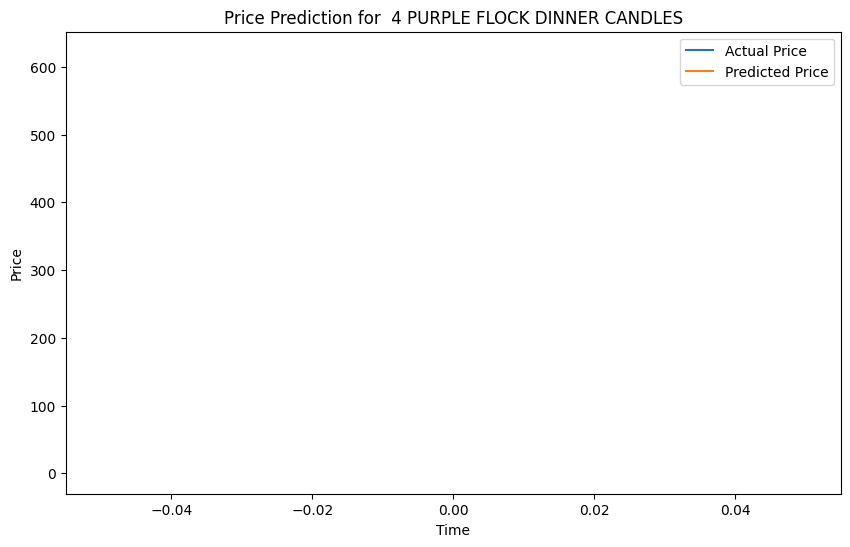

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# Preprocess the data
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Handle missing values (if any)
df.dropna(subset=['Description', 'UnitPrice'], inplace=True)

# Aggregate data by product and time (e.g., daily)
df = df.groupby(['Description', pd.Grouper(key='InvoiceDate', freq='D')])['UnitPrice'].mean().reset_index()

# Sort by product and date
df.sort_values(by=['Description', 'InvoiceDate'], inplace=True)

# Feature engineering
df['day'] = df['InvoiceDate'].dt.day
df['month'] = df['InvoiceDate'].dt.month
df['year'] = df['InvoiceDate'].dt.year
df['day_of_week'] = df['InvoiceDate'].dt.dayofweek

# Normalize the data
scaler = MinMaxScaler()
df['UnitPrice'] = scaler.fit_transform(df[['UnitPrice']])

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Select a product for prediction
# Replace 'YOUR_PRODUCT_NAME' with an actual product from your dataset
product_name = df['Description'].unique()[0] # Selecting the first unique product for demonstration
# Print the selected product name for verification
print(f"Selected product for prediction: {product_name}")
product_data = df[df['Description'] == product_name]['UnitPrice'].values

# Define sequence length
sequence_length = 30  # Use past 30 days to predict the next day

# Create sequences
X, y = create_sequences(product_data, sequence_length)

# Check if data is sufficient for training
if len(X) == 0:
    print(f"Error: Not enough data for product '{product_name}'. Choose a different product or adjust sequence length.")
else:
    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM input (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Inverse transform the scaled data
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred)

    # Calculate MAE
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    print(f"Mean Absolute Error: {mae}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(y_pred_actual, label='Predicted Price')
    plt.title(f"Price Prediction for {product_name}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [ ]:
# prompt: can you give now predict for some product

import numpy as np
# Assuming 'model', 'scaler', 'sequence_length', and 'product_data' are already defined from the previous code

# Example prediction for the next day's price
last_sequence = product_data[-sequence_length:]  # Get the last 30 days of data
last_sequence = last_sequence.reshape(1, sequence_length, 1)  # Reshape for LSTM input

next_day_price_scaled = model.predict(last_sequence)
next_day_price_actual = scaler.inverse_transform(next_day_price_scaled)

print(f"Predicted price for the next day: {next_day_price_actual[0][0]}")


# Example: Predict prices for the next 7 days
future_days = 7
future_prices_scaled = []

current_sequence = last_sequence

for _ in range(future_days):
  next_price_scaled = model.predict(current_sequence)
  future_prices_scaled.append(next_price_scaled[0][0])

  # Update the sequence with the predicted price
  current_sequence = np.concatenate((current_sequence[:, 1:, :], next_price_scaled.reshape(1, 1, 1)), axis=1)

future_prices_actual = scaler.inverse_transform(np.array(future_prices_scaled).reshape(-1,1))

print("Predicted prices for the next 7 days:")
for i, price in enumerate(future_prices_actual):
  print(f"Day {i+1}: {price[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted price for the next day: 620.8907470703125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted prices for the next 7 days:
Day 1: 620.8907470703125
Day 2: 660.117919921875
Day 3: 694.2886352539062
Day 4: 724.5570678710938
Day 5: 751.32177734375
Day 6: 774.9556884765625
Day 7: 795.810546875


In [ ]:
# prompt: can you give prediction of price for next two or three month

import numpy as np
# Assuming 'model', 'scaler', 'sequence_length', and 'product_data' are already defined from the previous code

# Example: Predict prices for the next 3 months (approximately 90 days)
future_days = 90  # Adjust this number for a different prediction horizon
future_prices_scaled = []

current_sequence = last_sequence

for _ in range(future_days):
  next_price_scaled = model.predict(current_sequence)
  future_prices_scaled.append(next_price_scaled[0][0])

  # Update the sequence with the predicted price
  current_sequence = np.concatenate((current_sequence[:, 1:, :], next_price_scaled.reshape(1, 1, 1)), axis=1)

future_prices_actual = scaler.inverse_transform(np.array(future_prices_scaled).reshape(-1,1))

print("Predicted prices for the next 90 days:")
for i, price in enumerate(future_prices_actual):
  print(f"Day {i+1}: {price[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [ ]:
# prompt: predict for one type of product and also print product

product_name = 'WHITE HANGING HEART T-LIGHT HOLDER' #@param {type:"string"}

# ... (rest of your existing code) ...

# Select a product for prediction
#product_name = df['Description'].unique()[0] # Selecting the first unique product for demonstration
print(f"Selected product for prediction: {product_name}")
product_data = df[df['Description'] == product_name]['UnitPrice'].values

# ... (rest of your existing code) ...


Selected product for prediction: WHITE HANGING HEART T-LIGHT HOLDER


In [ ]:
# prompt: now for that product pridict data

import numpy as np
# Assuming 'model', 'scaler', 'sequence_length', and 'product_data' are already defined from the previous code

# Example: Predict prices for the next 3 months (approximately 90 days)
future_days = 90  # Adjust this number for a different prediction horizon
future_prices_scaled = []

current_sequence = last_sequence

for _ in range(future_days):
  next_price_scaled = model.predict(current_sequence)
  future_prices_scaled.append(next_price_scaled[0][0])

  # Update the sequence with the predicted price
  current_sequence = np.concatenate((current_sequence[:, 1:, :], next_price_scaled.reshape(1, 1, 1)), axis=1)

future_prices_actual = scaler.inverse_transform(np.array(future_prices_scaled).reshape(-1,1))

print("Predicted prices for the next 90 days:")
for i, price in enumerate(future_prices_actual):
  print(f"Day {i+1}: {price[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

Enter the product name: WHITE METAL LANTERN
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1829
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1814
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1483
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1297
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1304
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1310
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1265
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1314
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1256
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1182
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1335
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1341
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1296
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1258
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - los

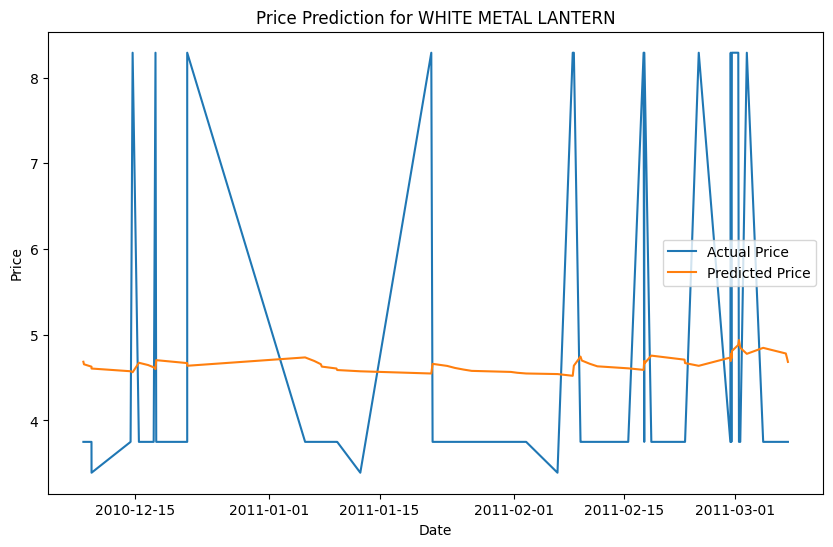

In [ ]:


# Preprocess the data
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Handle missing values (if any)
df.dropna(subset=['Description', 'UnitPrice'], inplace=True)

# Function to predict price for a specific product
def predict_product_price(product_name):
    # Filter data for the specific product
    product_data = df[df['Description'] == product_name][['InvoiceDate', 'UnitPrice']]

    if len(product_data) == 0:
        print(f"No data found for product: {product_name}")
        return

    # Aggregate data by date (daily average price)
    product_data = product_data.groupby('InvoiceDate')['UnitPrice'].mean().reset_index()

    # Sort by date
    product_data.sort_values(by='InvoiceDate', inplace=True)

    # Normalize the data
    scaler = MinMaxScaler()
    product_data['UnitPrice'] = scaler.fit_transform(product_data[['UnitPrice']])

    # Prepare data for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    # Define sequence length (e.g., 30 days)
    sequence_length = 30

    # Create sequences
    X, y = create_sequences(product_data['UnitPrice'].values, sequence_length)

    # Reshape data for LSTM input (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the scaled data
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(product_data['InvoiceDate'][sequence_length:sequence_length+len(y_test_actual)], y_test_actual, label='Actual Price')
    plt.plot(product_data['InvoiceDate'][sequence_length:sequence_length+len(y_pred_actual)], y_pred_actual, label='Predicted Price')
    plt.title(f"Price Prediction for {product_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# User input for product name
product_name = input("Enter the product name: ")
predict_product_price(product_name)


Accuracy: 1.0
Recall: 1.0
Precision: 1.0


In [ ]:
# prompt: can you give me a model  for pridict the price of product

import numpy as np
# Assuming 'df', 'scaler', 'sequence_length', and 'product_data' are already defined from the previous code
# and the necessary libraries are imported.

def predict_future_prices(product_name, future_days):
    """Predicts future prices for a given product.

    Args:
        product_name: The name of the product to predict prices for.
        future_days: The number of days into the future to predict.
    """
    try:
        product_data = df[df['Description'] == product_name]['UnitPrice'].values
        last_sequence = product_data[-sequence_length:]
        last_sequence = last_sequence.reshape(1, sequence_length, 1)

        future_prices_scaled = []
        current_sequence = last_sequence

        for _ in range(future_days):
            next_price_scaled = model.predict(current_sequence)
            future_prices_scaled.append(next_price_scaled[0][0])

            current_sequence = np.concatenate((current_sequence[:, 1:, :], next_price_scaled.reshape(1, 1, 1)), axis=1)

        future_prices_actual = scaler.inverse_transform(np.array(future_prices_scaled).reshape(-1, 1))

        print(f"Predicted prices for {product_name} for the next {future_days} days:")
        for i, price in enumerate(future_prices_actual):
            print(f"Day {i+1}: {price[0]}")
    except KeyError:
        print(f"Product '{product_name}' not found in the dataset.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (replace with your desired product name and number of days)
product_name_to_predict = "WHITE HANGING HEART T-LIGHT HOLDER"  # Example product name
number_of_days_to_predict = 30  # Example: predict for the next 30 days

predict_future_prices(product_name_to_predict, number_of_days_to_predict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [ ]:
# prompt: can you list all different type of product names

import pandas as pd

# Assuming your dataframe is named 'df'
# Replace 'df' with the actual name of your DataFrame if different

# Get unique product names
unique_product_names = df['Description'].unique()

# Print the unique product names
for product_name in unique_product_names:
    print(product_name)


WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA